In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *
from sklearn.datasets import make_classification
np.random.seed(42)

In [2]:
# Code given in the question
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)


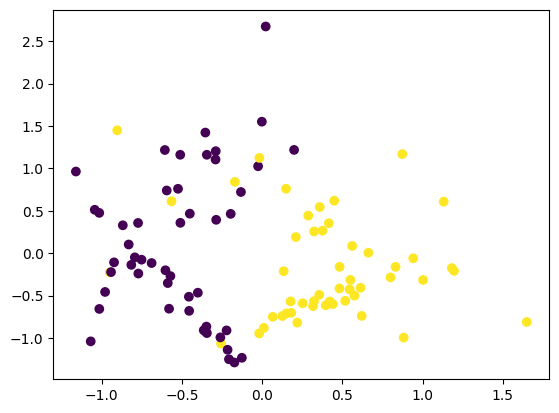

In [3]:
# For plotting
plt.scatter(X[:, 0], X[:, 1], c=y)

In [12]:
X = pd.DataFrame(X, columns=["X1", "X2"])
y = pd.Series(y, dtype="category")

In [13]:
# Train-test split (70%-30%)
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [14]:
print("Train data length: ", len(X_train))
print("Test data length: ", len(X_test))

Train data length:  70
Test data length:  30


In [15]:
tree = DecisionTree(criterion="information_gain", max_depth=5)
tree.fit(X_train, y_train)

In [19]:
print("Accuracy:", accuracy(y_pred, y_test))
for cls in y.unique():
    print(f"Class {cls} -> Precision: {precision(y_pred, y_test, cls)}, Recall: {recall(y_pred, y_test, cls)}")


Accuracy: 0.9
Class 1 -> Precision: 0.8947368421052632, Recall: 0.9444444444444444
Class 0 -> Precision: 0.9090909090909091, Recall: 0.8333333333333334


In [25]:
def k_fold_indices(n_samples, k=5, shuffle=True, random_state=42):
    if shuffle:
        np.random.seed(random_state)
        indices = np.random.permutation(n_samples)
    else:
        indices = np.arange(n_samples)
    
    fold_sizes = [n_samples // k] * k
    for i in range(n_samples % k):
        fold_sizes[i] += 1
    
    current = 0
    folds = []
    for fold_size in fold_sizes:
        folds.append(indices[current:current + fold_size])
        current += fold_size
    return folds

folds = k_fold_indices(len(X), k=5)

In [27]:
max_depth_values = [1, 2, 3, 4, 5, 6, 7]  # candidate depths
outer_results = []

for i, test_idx in enumerate(folds):
    # Outer split
    train_idx = np.hstack([folds[j] for j in range(len(folds)) if j != i])
    X_train_outer, y_train_outer = X.loc[train_idx], y.loc[train_idx]
    X_test_outer, y_test_outer = X.loc[test_idx], y.loc[test_idx]

    # Inner CV for hyperparameter tuning
    best_depth = None
    best_acc = -np.inf
    
    for depth in max_depth_values:
        inner_accs = []
        inner_folds = k_fold_indices(len(X_train_outer), k=5)
        for j, val_idx in enumerate(inner_folds):
            train_idx_inner = np.hstack([inner_folds[m] for m in range(len(inner_folds)) if m != j])
            X_train_inner, y_train_inner = X_train_outer.iloc[train_idx_inner], y_train_outer.iloc[train_idx_inner]
            X_val_inner, y_val_inner = X_train_outer.iloc[val_idx], y_train_outer.iloc[val_idx]
            
            tree = DecisionTree(criterion="information_gain", max_depth=depth)
            tree.fit(X_train_inner, y_train_inner)
            y_pred_inner = tree.predict(X_val_inner)
            inner_accs.append(accuracy(y_pred_inner, y_val_inner))
        
        avg_inner_acc = np.mean(inner_accs)
        if avg_inner_acc > best_acc:
            best_acc = avg_inner_acc
            best_depth = depth
    # Train on full outer training set with best depth
    final_tree = DecisionTree(criterion="information_gain", max_depth=best_depth)
    final_tree.fit(X_train_outer, y_train_outer)
    y_pred_outer = final_tree.predict(X_test_outer)
    
    outer_results.append({
        "fold": i+1,
        "best_depth": best_depth,
        "accuracy": accuracy(y_pred_outer, y_test_outer)
    })
    

In [28]:
for res in outer_results:
    print(f"Fold {res['fold']}: Best Depth = {res['best_depth']}, Accuracy = {res['accuracy']:.4f}")


Fold 1: Best Depth = 2, Accuracy = 0.9500
Fold 2: Best Depth = 2, Accuracy = 0.8000
Fold 3: Best Depth = 1, Accuracy = 0.8500
Fold 4: Best Depth = 2, Accuracy = 0.9500
Fold 5: Best Depth = 4, Accuracy = 0.9000


In [29]:
avg_acc = np.mean([res['accuracy'] for res in outer_results])
print(f"\nAverage Accuracy (5-fold CV with nested tuning) = {avg_acc:.4f}")


Average Accuracy (5-fold CV with nested tuning) = 0.8900


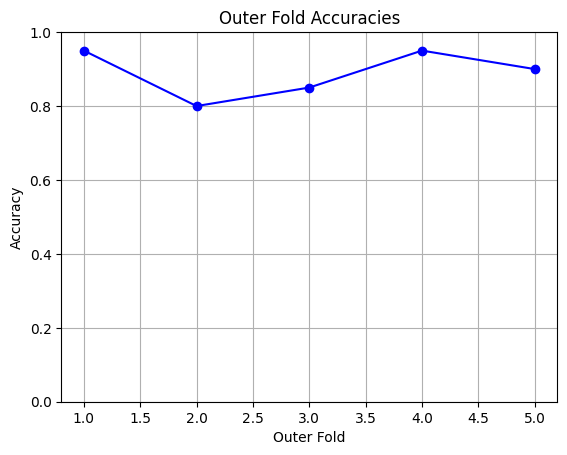

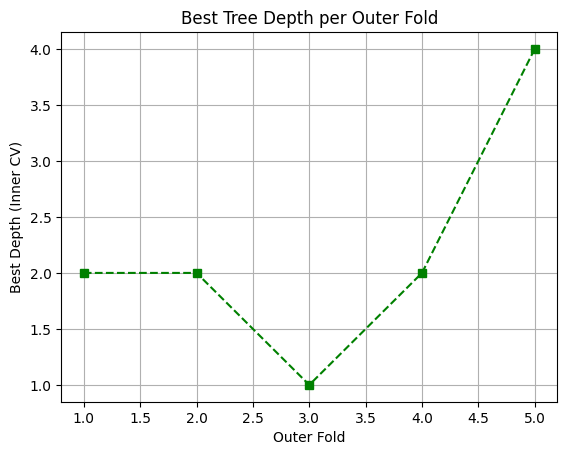

In [31]:
folds = [r["fold"] for r in outer_results]
best_depths = [r["best_depth"] for r in outer_results]
outer_acc = [r["accuracy"] for r in outer_results]

# Outer fold accuracy plot
plt.plot(folds, outer_acc, marker='o', linestyle='-', color='blue')
plt.xlabel("Outer Fold")
plt.ylabel("Accuracy")
plt.title("Outer Fold Accuracies")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Best depth per fold
plt.plot(folds, best_depths, marker='s', linestyle='--', color='green')
plt.xlabel("Outer Fold")
plt.ylabel("Best Depth (Inner CV)")
plt.title("Best Tree Depth per Outer Fold")
plt.grid(True)
plt.show()
